# Training a simple BDT using scikit-learn
#### `Justin Tan, CoEPP - 02/02/2017`

Machine learning is a key part of multivariate analysis in particle physics. In this notebook we will train a simple BDT to tackle the binary classification problem: discriminating signal from a continuum background. This notebook makes use of Python's `scikit-learn`, and use a range of metrics to evaluate classifier performance. We assume features are given as ROOT format and cast them to `numpy` arrays using the excellent `root_numpy` package. All subsequent analysis is fully general.

`TMVA` in ROOT :seedling: has distinct advantages - such as simple macros and a useful GUI to aid visualization, but is relatively rigid and has a steep learning curve. In the Kaggle Higgs ML challenge, traditional BDTs trained using `TMVA` ranked lower than 300th in the final leaderboards. The winning entry was an ensemble of > 70 neural networks utilizing methods that would be either unavailable or a lot of work to implement in TMVA (eg. dropout, XGBoost, stratified CV)...

`scikit-learn` is much more flexible and offers a range of modern tools unavailable in the `TMVA` library, which may help to push your analysis that one step further.

### `TO-DO:`
1. Feature Selection
  - Intelligent feature ranking
  - Automated feature selection
  - Explore feature engineering
2. Model improvements
  - Hyperparameter grid search (minor)
  - Regularization. Lots.
  - Train sub-BDTs throughout decay chain (Hierarchial?) 
  - Port to TensorFlow (Neural nets)
3. Performance evaluation
  - Develop better metrics

In [27]:
import random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from root_numpy import root2array, rec2array, array2root
import ROOT
import sys, glob, os, time

from sklearn import datasets

mpl.rcParams.update({'font.size': 12})

## Data visualization 

Its always helpful to visualize data before beginning an extended training run. Highly correlated variables may render the tree structure unstable to statistical fluctuations and generally does not help with separation power.

In [28]:
def plot_correlations(data, mode):
    # Plot correlation matrix elements between features as a heatmap
    corrmat = data.corr()
    f, ax = plt.subplots(figsize=(14,11))
    sns.heatmap(corrmat, square=True, cmap='RdBu')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    f.tight_layout()
    plt.title(r"$\mathrm{Correlation \; Coefficients}$")
    f.savefig('graphs/' + mode + 'correlations.pdf',  format='pdf', dpi=1000)
    plt.show()
    plt.gcf().clear()

In [29]:
def truncate_tails(hist, nsigma = 4.5):
    hist = hist[hist > np.mean(hist)-nsigma*np.std(hist)]
    hist = hist[hist < np.mean(hist)+nsigma*np.std(hist)]
    return hist

In [30]:
def compare_histograms(data_sig, data_bkg, mode, nbins = 50, columns=None):
    # Plot continuum suppression variable distributions for signal, background
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    if (not columns):
        columns_sig = [data_sig[variable].values for variable in columns]
        columns_bkg = [data_bkg[variable].values for variable in columns]
        if (columns_sig != columns_bkg):
            raise ValueError('Both input dataframes must have identically named columns!\n')
            return
    for variable in columns:
        data_array_sig = data_sig[variable].values
        d_bkg = data_bkg[variable].values
        
        # Truncate problematic tails
        data_array_bkg = truncate_tails(d_bkg)
        
        plt.hist(data_array_sig, bins=nbins, alpha=0.5, color = sea_green, label = 'Signal', 
                 weights = np.ones(data_array_sig.shape[0])*1/data_array_sig.shape[0])
        plt.hist(data_array_bkg, bins=nbins, alpha=0.3, color = steel_blue, label = 'Background', 
                 weights = np.ones(data_array_bkg.shape[0])*1/data_array_bkg.shape[0])
        plt.title(variable)
        #plt.title(r"$\mathrm{"+variable+"{\; - \; (B \rightarrow K^+ \pi^0) \gamma$")
        plt.xlabel(variable)
        plt.ylabel(r'$\mathrm{Fractional events per bin}$')
        plt.legend(loc = "upper right")
        plt.savefig('graphs/' + mode + variable + '.pdf',format='pdf', dpi=1000)
        plt.show()
        plt.gcf().clear()

## Performance Evaluation

Ranks features by the expected fraction of events they directly classify. Yields crude estimation of feature importance, but subject to statistical fluctuations.

In [31]:
def plot_feature_rank(bdt, mode, branch_names):
    # Rank features by the expected fraction of input events they contribute to the classification of
    # update with a smarter version
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    
    importances = bdt.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in bdt.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    ranked_labels = [branch_names[rank] for rank in indices]

    for f in range(features.shape[1]):
        print("%d. feature %d - %s `(%f)" % (f + 1, indices[f], branch_names[indices[f]], importances[indices[f]]))
    
    # Plot feature importances
    plt.figure(figsize=(14,11))
    plt.title("Feature ranking")
    plt.bar(range(features.shape[1]), importances[indices], color=steel_blue, align='center')
    plt.xticks(range(features.shape[1]), indices)
    plt.xlim([-1,features.shape[1]])
    plt.xticks(np.arange(len(ranked_labels)), ranked_labels, rotation = 90)
    plt.savefig("graphs/" + mode + "simplefeaturerank.pdf",format='pdf', dpi=1000)
    plt.show()
    plt.gcf().clear()

In [32]:
def plot_ROC_curve(clf, X_val, y_val, mode, meta_info):
    # Plots receiver operating characteristic for given classifier
    from sklearn.metrics import roc_curve, auc
    # Compute BDT decision function on validation data
    decisions = clf.decision_function(X_val)
    # Compute ROC curve, integrate
    fpr, tpr, thresholds = roc_curve(y_val, decisions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.axes([.1,.1,.8,.7])                           
    plt.figtext(.5,.9, r'$\mathrm{Receiver \;operating \;characteristic}$', fontsize=15, ha='center')
    plt.figtext(.5,.85, meta_info,fontsize=10,ha='center')
    plt.plot(fpr, tpr, color='darkorange',
                     lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1.0, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel(r'$\mathrm{False \;Positive \;Rate}$')
    plt.ylabel(r'$\mathrm{True \;Positive \;Rate}$')
    plt.legend(loc="lower right")
    plt.savefig("graphs/" + mode + "ROCcurve.pdf",format='pdf', dpi=1000)
    plt.show()
    plt.gcf().clear()

In [33]:
def plot_BDT_output_balanced(clf, X_train, X_test, y_train, y_test, tree_name, meta_info, numbins=25):
    # Plot classifier decision function for each class. superimpose classifier output for
    # training sample and the independent validation sample to check for overfitting, use
    # only if classes are relatively balanced
    decisions = []
    # Run classifier on train, test data. Unravel to flattened array
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1,d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    hist_range = (low,high)

    plt.figure()
    plt.axes([.1,.1,.8,.7])
    plt.figtext(.5,.9, 'BDT Output', fontsize=12, ha='center')
    plt.figtext(.5,.86, meta_info, fontsize=8, ha='center')

    # Histogram training data
    plt.hist(decisions[0], color = 'g', alpha = 0.5, range = hist_range, bins = numbins, histtype='stepfilled', label='Signal (train)')
    plt.hist(decisions[1], color = 'b', alpha = 0.5, range = hist_range, bins = numbins, histtype='stepfilled', label='Background (train)')

    # Overlay training histogram with test data histogram, plotted as error-bar histograms
    hist, bins = np.histogram(decisions[2], bins=numbins, range=hist_range)
    err = np.sqrt(hist)
    center = (bins[:-1] + bins[1:])/2

    plt.errorbar(center, hist, yerr = err, fmt='o',c='g', label = 'Signal (test)')

    hist, bins = np.histogram(decisions[3], bins=numbins, range=hist_range)
    err = np.sqrt(hist)
    center = (bins[:-1] + bins[1:])/2

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label = 'Background (test)')
    plt.xlabel("Classifier Output")
    plt.ylabel("Entries/bin")
    plt.legend(loc='best')
    plt.savefig("graphs/" + tree_name + "BDToutput.png")
    plt.show()
    plt.gcf().clear()

## Model persistence + Preprocessing

In [34]:
# Specify branch names you don't want to feed into the classifier
def pruned(branch_names):
    unwanted = ['hso01', 'hso03','Signal', 'B0__momDevChi2','X','Y','Z','VtxProd', 'isNot', 'nCands', 'iCand', 'B0__isNotContinuumEvent', 'B0__SigM']
    unwanted += ['Rho', 'Pvalue', 'dr', 'dz', 'Vert', 'Prob', 'DevChi','B0__momDevChi2']
    unwanted += ['B__InvM', 'B__m2Recoil', 'B__DeltaB', 'B_DeltaT']
    pruned_branch_list = []
    for feature in branch_names:
        flag = False
        for bad_string in unwanted:
            if (bad_string in feature):
                    flag = True
        if (not flag):
            pruned_branch_list += [feature]
    return pruned_branch_list

In [35]:
def output_to_ROOT(clf, X):
    
    # Outputs BDT predictions on entire dataset to a ROOT file for later analysis

    y_predicted = bdt.decision_function(X)
    y_predicted.dtype = [('y', np.float64)]

    array2root(y_predicted, "clf_output.root", "BDToutput")

In [36]:
def save_classifier(clf, filename):
    # Save classifier for later reuse, reload with:
    # >> clf = joblib.load(filepath)

    from tempfile import mkdtemp
    import os
    savedir = mkdtemp()
    filepath = os.path.join(savedir, filename)
    joblib.dump(clf, filepath)
    print("Saved at:" + filepath)
    return filepath

## The main body

We load the input data from a pair of ROOT files generated by a BASF2 steering file for the decay chain, available on the Github project page. Currently training is done using various $B \rightarrow X_q \gamma$ modes, using analysis-specific signal side selection.

$$ 
\begin{align}
B^0 &\rightarrow (K^{*0} \rightarrow K^+ \pi^-) \; \gamma \\
B^0 &\rightarrow (K^{*0} \rightarrow K_S^0 \pi^0) \; \gamma \\
B^+ &\rightarrow (K^{*+} \rightarrow K_S^0 \pi^+) \; \gamma \\
B^+ &\rightarrow (K^{*0} \rightarrow K^+ \pi^0) \; \gamma \\
B^0 &\rightarrow (\rho^0 \rightarrow \pi^+ \pi^-) \; \gamma \\
B^+ &\rightarrow (\rho^+ \rightarrow \pi^+ \pi^0) \; \gamma
\end{align}
$$

The classifier was trained on $2.4$ million signal events and $X$ million continuum $q\bar{q}$ events. The preselection discarded nearly all continuum events so it is crucial to include enough Monte Carlo events to obtain a reasonable statistic for training. Training using this dataset took $X$ hours at KEKCC.

### ROOT to NumPy conversion

We convert the event data stored in the ROOT signal and background files to numpy arrays using the `root_numpy` package. We can control the features we want to train on by extracting the branch names directly from the ROOT TTree and pruning the unwanted branches.

In [41]:
# Specify input ROOT files here and the decay mode
sig_input = "ewp/rhoplus/Bplus2rhogammasignal.root"
bkg_input = "ewp/rhoplus/Bplus2rhogammaqqbar.root"
X_d_input = "ewp/rhoplus/Bplus2rhogammaX_d.root"
crossfeed = "ewp/rhoplus/Bplus2rhogammaX_s.root"
generic = "ewp/rhoplus/Bplus2rhogammageneric.root"
mode = "Bplus2rhoplus_gamma"

In [48]:
# Read ROOT files into numpy arrays
sigFile = ROOT.TFile(sig_input)
bkgFile = ROOT.TFile(bkg_input)
cfdFile = ROOT.TFile(crossfeed)
genFile = ROOT.TFile(generic)

sig_tree_names = [key.GetName() for key in sigFile.GetListOfKeys()]
bkg_tree_names = [key.GetName() for key in bkgFile.GetListOfKeys()]
cfd_tree_names = [key.GetName() for key in cfdFile.GetListOfKeys()]
tree = 'B+'

sigTree = sigFile.Get(tree)
bkgTree = bkgFile.Get(tree)
cfdTree = cfdFile.Get(tree)

# Prune unwanted branches from the TTree, try CS only
original_names = [b.GetName() for b in sigTree.GetListOfBranches()]
sig_branch_names = pruned([b.GetName() for b in sigTree.GetListOfBranches()])[:30]#[30:] + ['B_ThrustB','B_CosTBTO','B_cc1']
bkg_branch_names = pruned([b.GetName() for b in bkgTree.GetListOfBranches()])[:30]#[30:] + ['B_ThrustB','B_CosTBTO','B_cc1']
cfd_branch_names = pruned([b.GetName() for b in cfdTree.GetListOfBranches()])[:30]#[30:] + ['B_ThrustB','B_CosTBTO','B_cc1']

if (sig_branch_names != bkg_branch_names or sig_branch_names != cfd_branch_names):
    print("Error! Feature lists should be consistent between signal and background.")

branch_names = sig_branch_names
branch_names.append('B__isSignal')

#branch_names = [b.replace("__", "_") for b in branch_names]

signal = root2array(sig_input, tree, branch_names)
signal = rec2array(signal)

bkg = root2array(bkg_input, tree, branch_names)
bkg = rec2array(bkg)

cfd = root2array(crossfeed, tree, branch_names)
cfd = rec2array(cfd)

gen = root2array(generic, tree, branch_names)
gen = rec2array(gen)

Next we extract the features from the data, and generate truth labels. The complete dataset is stored as a Pandas dataframe for easy access. The dataset is paritioned into training and testing sets twice to ensure no overfitting occurs when we exploit the validation set for hyperparameter tuning.

In [52]:
from sklearn.cross_validation import train_test_split

# scikit-learn data organized into 2D array of shape (n_samples, n_features)
labels = np.concatenate((signal[:,-1], bkg[:,-1]))
signal = np.delete(signal,-1,1)
bkg = np.delete(bkg,-1,1)
branch_names.remove('B__isSignal')
features = np.concatenate((signal,bkg))

# labels = np.concatenate((np.ones(signal.shape[0]), np.zeros(bkg.shape[0])))

# Store data in pandas dataframe - 2D size mutable tabular structure with labelled axes
# permits quick operations on features
df = pd.DataFrame(np.hstack((features, labels.reshape(labels.shape[0],-1))), columns = branch_names + ['labels'])

# Access rows in dataframe satisfying this condition
bkg_bool = df['labels'] < 0.5
sig_bool = df['labels'] > 0.5

# We parititon the data into separate training, testing sets twice
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.15, random_state=432)
X_use, X_val, y_use, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 213)

## Feature Visualization

### Comparing feature distributions

The distribution of features with the strongest discriminating power between signal and background for this particular model is plotted below.

1. feature 32 - B0__q2Bh `(0.058507)
2. feature 5 - B0_cc1 `(0.041430)
3. feature 36 - B0__chiProb `(0.038360)
4. feature 38 - B0__daughterAngle__bo0__cm1__bc `(0.037655)
5. feature 23 - B0_hso14 `(0.033928)

Distributions are overlaid from each of the 4 classes of data: Signal, Continuum background, Crossfeed and Generic

In [46]:
def compare_histograms_overlay(data_sig, data_bkg, data_cfd, data_gen, tree_name, branch_names, nbins = 50, columns=None):
    # Plot continuum suppression variable distributions for signal, background
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    crimson_tide = '#cc0000'
    yellow = '#ffff00'
    orange = '#ffa500'

    for variable in columns:
        data_array_sig = data_sig[variable].values
        d_bkg = data_bkg[variable].values
        # Truncate problematic tails
        data_array_bkg = truncate_tails(d_bkg)
        d_cfd = data_cfd[:,branch_names.index(variable)]
        d_gen = data_gen[:,branch_names.index(variable)]
        
        sns.distplot(data_array_sig,color = sea_green, hist=True,label = r'$\mathrm{Signal}$',bins=nbins)       
        sns.distplot(data_array_bkg,color = steel_blue, hist=True,label = r'$\mathrm{Continuum}$',kde=False,norm_hist=True,bins=nbins)
        sns.distplot(d_cfd, color = crimson_tide, label = r'$\mathrm{Crossfeed}$', hist=True,kde=False,norm_hist=True,bins=nbins)
        sns.distplot(d_gen, color = yellow, label = r'$\mathrm{Generic}$', hist=True,kde=False,norm_hist=True,bins=nbins)

#         sns.kdeplot(data_array_bkg, color = steel_blue, label = 'Background',shade =True)
#         sns.kdeplot(d_cfd, color = crimson_tide, label = 'Crossfeed',shade =True)
#         sns.kdeplot(d_gen, color = yellow, label = 'Generic',shade =True)

        #plt.hist(data_array_sig, bins=nbins, alpha=0.5, color = sea_green, label = 'Signal', 
                 #weights = np.ones(data_array_sig.shape[0])*1/data_array_sig.shape[0], histtype='step',linewidth=2.0)
        #plt.hist(data_array_bkg, bins=nbins, alpha=0.3, color = steel_blue, label = 'Background', 
                 #weights = np.ones(data_array_bkg.shape[0])*1/data_array_bkg.shape[0],histtype='step',linewidth=2.0)
        #plt.hist(d_cfd, bins=nbins, alpha=0.3, color = crimson_tide, label = 'Crossfeed', 
                 #weights = np.ones(d_cfd.shape[0])*1/d_cfd.shape[0],histtype='step',linewidth=2.0)
        #plt.hist(d_gen, bins=nbins, alpha=0.4, color = yellow, label = 'Generic', 
                 #weights = np.ones(d_gen.shape[0])*1/d_gen.shape[0],histtype='step',linewidth=2.0)
        #plt.title(variable)
        #plt.title(r"$\mathrm{"+variable+"{\; - \; (B \rightarrow K^+ \pi^0) \gamma$")
        #plt.xlabel(variable)
        plt.ylabel(r'$\mathrm{Normalized \; events/bin}$')
        plt.legend(loc = "best")
        #plt.xlim(0,0.98)
        #plt.ylim(0,3.3)
        plt.xlabel(r'$|(p_B)_{CMS}| \; [GeV/c]$')
        plt.savefig('graphs/' + mode + variable + '.pdf', bbox_inches='tight',format='pdf', dpi=1000)
        plt.show()
        plt.gcf().clear()

In [27]:
def compare_histograms(data_sig, data_bkg, tree_name, nbins = 50, columns=None):
    # Plot continuum suppression variable distributions for signal, background
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    if (not columns):
        columns_sig = [data_sig[variable].values for variable in columns]
        columns_bkg = [data_bkg[variable].values for variable in columns]
        if (columns_sig != columns_bkg):
            raise ValueError('Both input dataframes must have identically named columns!\n')
            return
    for variable in columns:
        data_array_sig = data_sig[variable].values
        d_bkg = data_bkg[variable].values
        
        # Truncate problematic tails
        data_array_bkg = truncate_tails(d_bkg)
        
        plt.hist(data_array_sig, bins=nbins, alpha=0.5, color = sea_green, label = 'Signal', 
                 weights = np.ones(data_array_sig.shape[0])*1/data_array_sig.shape[0])
        plt.hist(data_array_bkg, bins=nbins, alpha=0.3, color = steel_blue, label = 'Background', 
                 weights = np.ones(data_array_bkg.shape[0])*1/data_array_bkg.shape[0])
        plt.title(variable)
        #plt.title(r"$\mathrm{"+variable+"{\; - \; (B \rightarrow K^+ \pi^0) \gamma$")
        plt.xlabel(variable)
        plt.ylabel(r'$\mathrm{Fractional \; events/bin}$')
        plt.legend(loc = "upper right")
        plt.savefig('graphs/' + mode + variable + '.pdf', format='pdf', dpi=1000)
        plt.show()
        plt.gcf().clear()

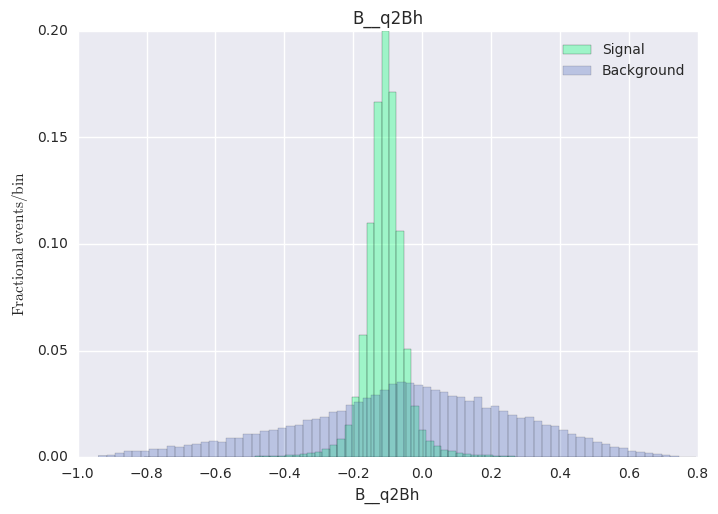

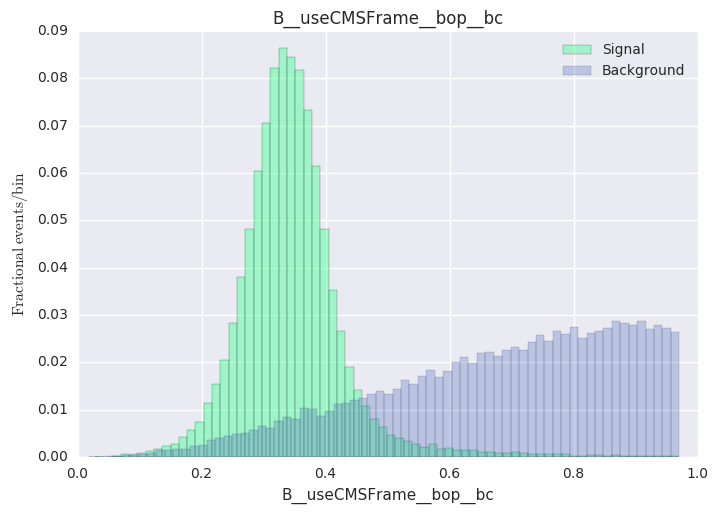

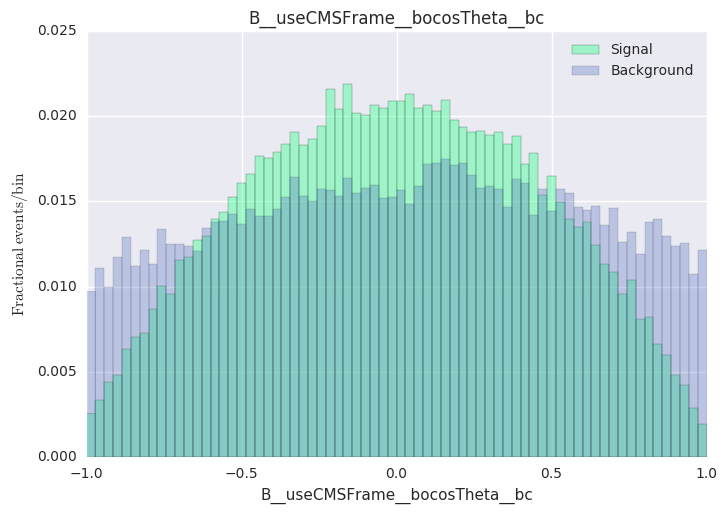

In [28]:
compare_histograms(df[sig_bool], df[bkg_bool], mode, 70, branch_names[0:3])

/home/justan/anaconda3/envs/py34/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


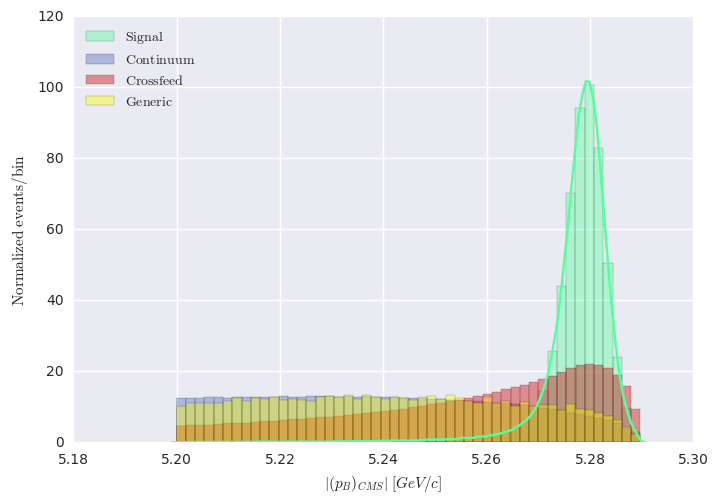

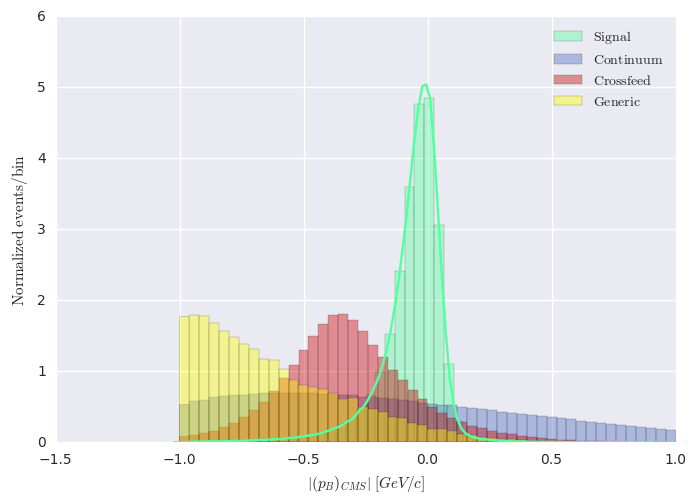

In [47]:
compare_histograms_overlay(df[sig_bool], df[bkg_bool], cfd, gen, mode, branch_names, 50, ['B_mbc','B_deltae'])

### Plot feature correlations

Plot feature correlations for both signal and background, as mentioned previously, the BDT structure is unstable against statistical fluctuations if highly correlated features are used during training.

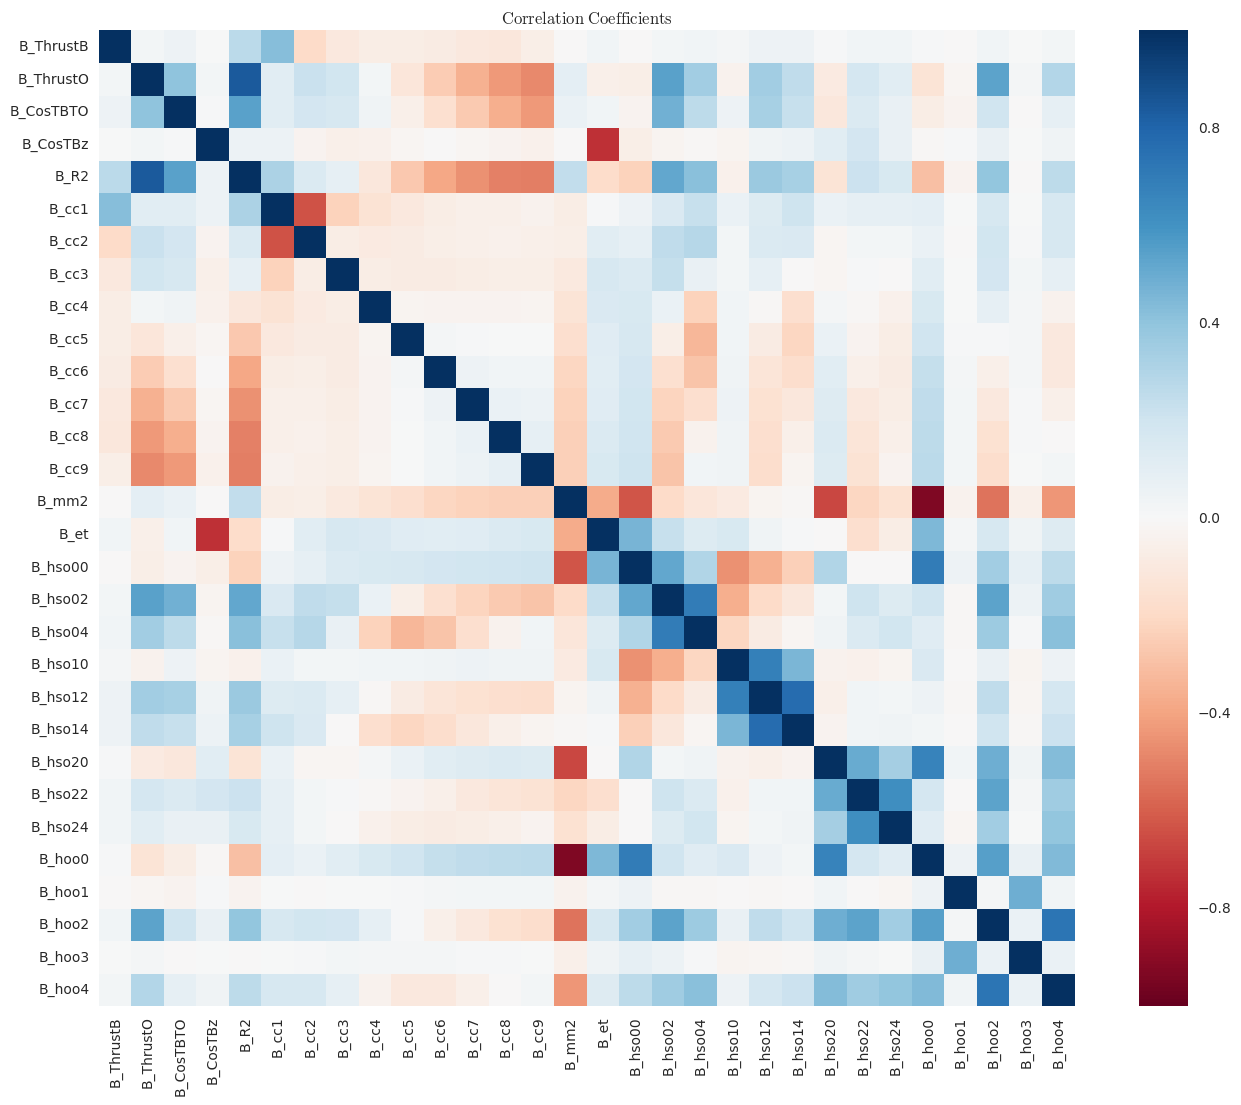

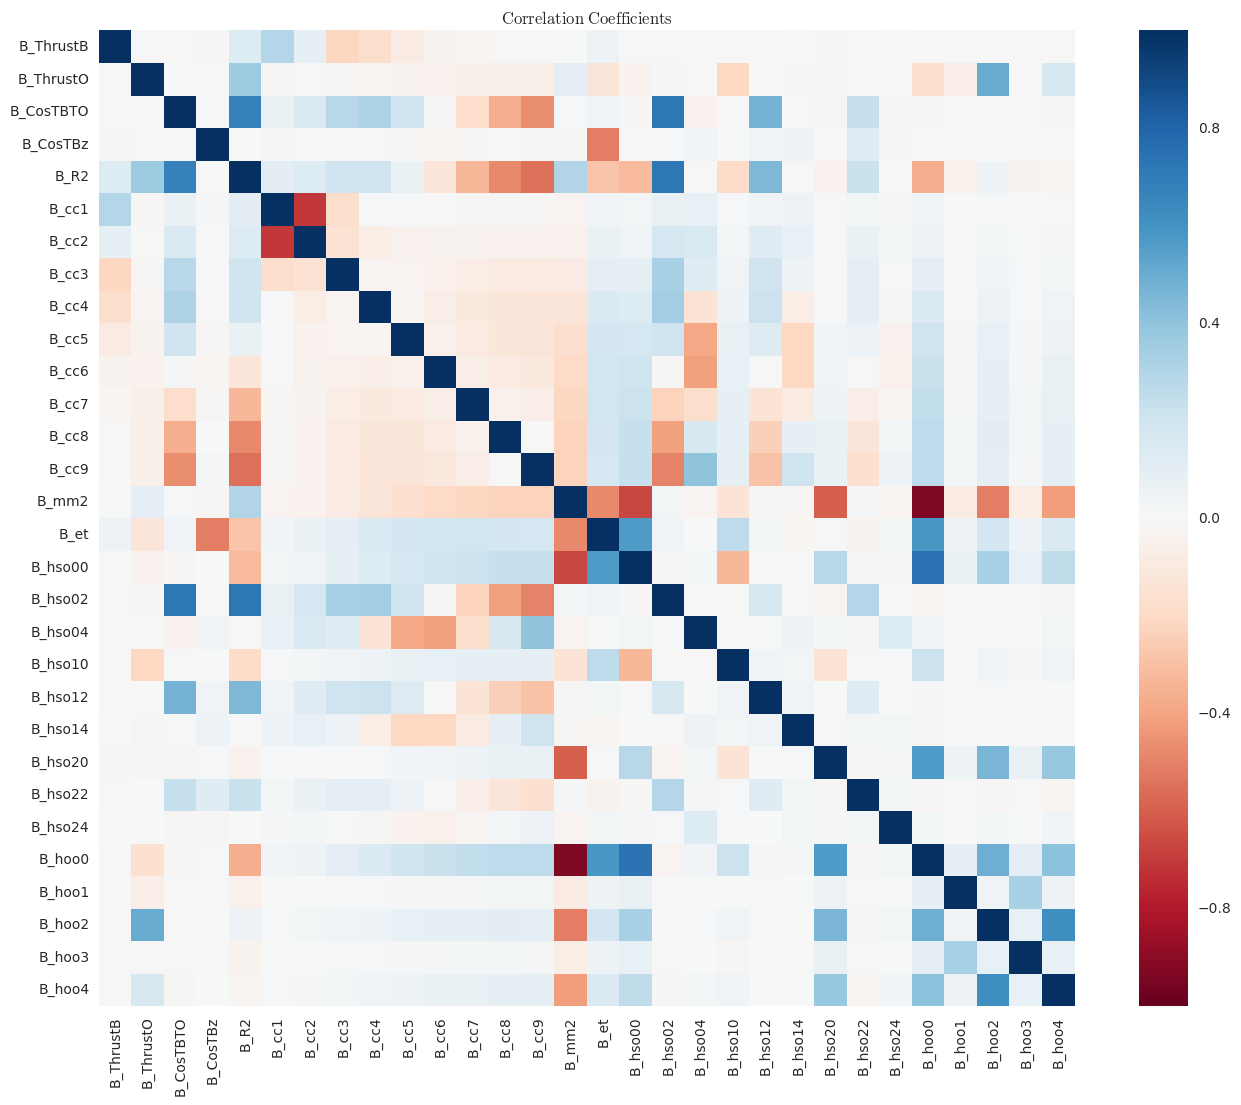

In [53]:
plot_correlations(df[bkg_bool].drop('labels',1), mode + 'BKG')
plot_correlations(df[sig_bool].drop('labels',1), mode + 'SIG')

## Training the Decision Tree

#### AdaBoost

With `scikit-learn`, training a classifier is embarassingly easy. As always, there is a convenience-power tradeoff. The hyperparameters of your model can be optimized via a grid search. Here we use some values commonly found in the Belle/Belle II literature, and the **Ada**ptive **Boost**ing (AdaBoost) algorithm. Other classifiers are very easily trained, see the `scikit-learn` [documentation](http://scikit-learn.org/stable/modules/ensemble.html#adaboost) for more information on available classifiers. 

A decision tree recursively partitions feature space into regions classifiable as 'signal' or 'background' using a suitable metric. We choose our impurity measure as the Gini Index. Intuitively, a decision tree filters impure mixtures of classes to relatively pure samples at the terminal nodes. The impurity metric should be strictly concave to reward purer nodes, symmetric between classes and minimal for pure nodes. 

At a bifurcation in the decision tree the variable and cut value that maximizes the decrease in impurity between the parent and daughter nodes, weighted by their relative fraction of events is chosen. The multiclass Gini index has a straightforward interpretation as the probability of misclassification.

$$ \sum_{i, j \; \in \; \mathrm{classes}}^{i \neq j} p_i p_j $$

$$ \mathrm{Binary:} \; G = p_s(1-p_s) + p_b(1-p_b) = 1 - (1-p)^2 - p^2 = 2p(1-p) $$

If we define the signal and background purity as below, we get a simple expression for the criterion.

$$ p_s = \frac{s}{s+b}, \: p_b = \frac{b}{s+b} \implies G = \frac{2sb}{(s+b)^2}
$$

**Caution:** run the following cell only if loading a pretrained classifier!

In [229]:
from sklearn.externals import joblib
bdt = joblib.load('/scratch/tmp1eio13xb/myBDT_rhoplus_crossfeed.pkl')
clf_meta = "AdaBoost - criterion=Gini, max_depth=4, n_est=2000, beta=0.5"

Here we start our model out with $800$ estimators, a maximum tree depth of $5$, and $\beta =0.5$

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.externals import joblib

# Set model hyperparameters
CRITERION = "gini"
MAX_DEPTH = 4
MIN_SAMPLES_LEAF = 0.05 
MIN_IMPURITY_SPLIT = 1e-7
BETA = 0.5
BASE_ESTIMATORS = 2500
clf_meta = "AdaBoost BDT - criterion = "+str(CRITERION)+", max_depth = "+str(MAX_DEPTH)+", base_est="+str(BASE_ESTIMATORS)+", beta="+str(BETA)

# Omit deltaE, Mbc from feature list
omit_variables = ['B_mbc', 'B_deltae']
flag = 0
for variable in omit_variables:
    if variable in branch_names:
        variable_index = branch_names.index(variable)
        reduced_X_use = np.delete(X_use, variable_index, 1)
        flag = 1
if (not flag):
    reduced_X_use = X_use

# Begin classifier training ________________________________________________________________________________________________________
t0 = time.time()
print("Training starts now")
# Select base classifier
dt = DecisionTreeClassifier(criterion = CRITERION, max_depth = MAX_DEPTH, min_samples_leaf = MIN_SAMPLES_LEAF, max_features = 'auto') # class_weight="balanced") 
# Adaptive boosting algorithm
bdt = AdaBoostClassifier(dt, n_estimators = BASE_ESTIMATORS, learning_rate = BETA)
# Train the classifier on selected data
%time bdt.fit(reduced_X_use, y_use)

print("Training complete. Time elapsed: %0.3fs" % (time.time() - t0))
clf_meta += ', training: %ds' % (time.time() - t0)
# Model persistance
save_path = save_classifier(bdt, filename = 'myBDT'+mode+'.pkl')
clf_meta = open('clf_meta','r+'):
    clf_meta.write(clf_meta)
    
# To resume, bdt = joblib.load(save_path)

Training starts now


#### Gradient Boosting + ExtraTrees Classifier

We can also train a gradient boosting + ExtraTrees classifier for comparison.

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

# Set model hyperparameters
MAX_DEPTH = 3
MAX_FEATURES = 'sqrt'
MIN_SAMPLES_LEAF = 0.04 
MIN_IMPURITY_SPLIT = 1e-7
BETA = 0.1
BASE_ESTIMATORS = 2000
SUBSAMPLE = 0.95
gbt_meta = "GBT - criterion = "+str(CRITERION)+", max_depth = "+str(MAX_DEPTH)+", base_est="+str(BASE_ESTIMATORS)+", beta="+str(BETA)

gbt = GradientBoostingClassifier(n_estimators = BASE_ESTIMATORS,
                                 max_depth = MAX_DEPTH,
                                 subsample = SUBSAMPLE,
                                 max_features = MAX_FEATURES,
                                 learning_rate = BETA)

# Begin classifier training ________________________________________________________________________________________________________
t0 = time.time()
print("Training starts now")
%time gbt.fit(reduced_X_use, y_use)

print("Training complete. Time elapsed: %0.3fs" % (time.time() - t0))

# Model persistance
save_path = save_classifier(gbt, filename = 'myGBT_rhoplus.pkl')
# To resume, bdt = joblib.load(save_path)

Training starts now
CPU times: user 3min 35s, sys: 875 ms, total: 3min 35s
Wall time: 3min 32s
Training complete. Time elapsed: 212.254s
Saved at:/scratch/tmpqrndujal/myGBT_rhoplus.pkl


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Set model hyperparameters
MAX_DEPTH = 4
MAX_FEATURES = 'sqrt'
MIN_SAMPLES_LEAF = 0.04 
MIN_IMPURITY_SPLIT = 1e-7
BETA = 0.1
BASE_ESTIMATORS = 1800
SUBSAMPLE = 0.95

etc = ExtraTreesClassifier(n_estimators = BASE_ESTIMATORS,
                                 max_depth = MAX_DEPTH,
                                 max_features = MAX_FEATURES,
                                 class_weight = 'balanced_subsample',
                                 n_jobs=-1)

# Begin classifier training ________________________________________________________________________________________________________
t0 = time.time()
print("Training starts now")
%time etc.fit(reduced_X_use, y_use)

print("Training complete. Time elapsed: %0.3fs" % (time.time() - t0))

# Model persistance
save_path = save_classifier(etc, filename = 'myETC_rhoplus.pkl')
# To resume, bdt = joblib.load(save_path)

## Evaluating Feature Performance

Now we will plot some metrics to visualize the classifier performance.

### Classification Report

In [242]:
mbc_index = branch_names.index('B_mbc')
deltaE_index = branch_names.index('B_deltae')
reduced_X_use = np.delete(X_use, [mbc_index, deltaE_index], 1)
reduced_X_val = np.delete(X_val, [mbc_index, deltaE_index], 1)

In [236]:
def classifier_report(clf, X, y):
    S_0 = np.count_nonzero(y) # Total number of signal events in dataset X
    B_0 = np.shape(y)[0] - S_0
    S_f, B_f = 0,0
    
    y_pred = clf.predict(X)
    onehots = np.equal(y,y_pred)
    accuracy = np.count_nonzero(onehots)/np.shape(y)[0]
    
    for i in range(0,np.shape(y)[0]):
        if (y[i] and onehots[i]):
            S_f+=1
        elif ((not y[i]) and (not onehots[i])):
            B_f+=1
            
    signal_efficiency = S_f/S_0
    background_rejection = B_0/B_f
    
    print("Accuracy: %.3f\nSignal Efficiency: %.3f \nBackground Rejection: %.3f" 
          %(accuracy, signal_efficiency, background_rejection))

In [243]:
print("AdaBoost Report II:\n")
classifier_report(bdt,reduced_X_val,y_val)

AdaBoost Report II:

Accuracy: 0.936
Signal Efficiency: 0.936 
Background Rejection: 15.597


In [ ]:
print("ExtraTrees Report:\n")
classifier_report(etc,reduced_X_val,y_val)

In [39]:
print("Gradient Boosting Report:\n")
classifier_report(gbt,reduced_X_val,y_val)

Gradient Boosting Report:

Accuracy: 0.979
Signal Efficiency: 0.985 
Background Rejection: 30.591


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = gbt.predict(X_val)

print(classification_report(y_val, y_pred, target_names=["background", "signal"]))

### Receiver Operating Characteristic

The true positive rate (recall) is plotted against the false positive rate (probability of false alarm). Used to evaluate classifier performance as we vary its discrimination threshold. The BDT output is a continuous random variable $X$. Given a threshold parameter $T$, the instance is classified as signal is $X>T$ and background otherwise. The random variable $X$ should follow a probability density $f_{sig}(x)$ if is true signal, and $f_{bkg}(x)$ otherwise. The respective rates are therefore given as cumulative density functions:

$$ \mathbf{TPR}(T) = \int_T^{\infty} dx \; f_{sig}(x), \; \; \mathbf{FPR}(T) = \int_T^{\infty} dx \; f_{bkg}(x), $$ 

The ROC curve plots $\mathbf{TPR}(T)$ versus $\mathbf{FPR}(T)$ with the discrimination threshold as the varying parameter. The optimal point in ROC - space is $(0,1)$ in the upper left corner, which is the error-free point. The gradient and area of the ROC curve are also useful metrics. The latter will be used as a testing metric, and is given by:

$$ \mathrm{AUC} = \theta = \int_{-\infty}^{\infty} dT \; \mathbf{TPR}(T) \; \frac{d\; \mathbf{FPR}}{dT}(T) $$

In [217]:
from sklearn.metrics import classification_report, roc_auc_score

print("Area under ROC curve - BDT: %.3f" %(roc_auc_score(y_val, bdt.decision_function(reduced_X_val), average='weighted')))
print("Area under ROC curve - GBT: %.3f" %(roc_auc_score(y_val, gbt.decision_function(reduced_X_val), average='weighted')))
print("Area under ROC curve - ETC: %.3f" %(roc_auc_score(y_val, bdt.decision_function(reduced_X_val), average='weighted')))

plot_ROC_curve(bdt, reduced_X_val, y_val, sig_tree_names[0], clf_meta)

# recall = TP / (TP + FN)
# precision = TP / (TP + FP)

ValueError: Found input variables with inconsistent numbers of samples: [129441, 13838]

### Feature Ranking

Here the 'importance' of a feature is defined as the normalized reduction in the Gini criterion (the *Gini Importance*). Each bifurcation in the tree a on variable $X_i$ decreases the Gini impurity criterion for the descendent nodes relative to the parent node. The sum of the reduction of this criterion for each feature $\{X_1, ... X_N\}$ yields a simple importance metric. Similar ideas apply with binary cross-entropy.

In [40]:
plot_feature_rank(bdt, sig_tree_names[0], branch_names)

1. feature 5 - B_gamma__useCMSFrame__boE__bc `(0.055738)
2. feature 18 - B__useRestFrame__bodaughter__bo0__cm__spp__bc__bc `(0.051995)
3. feature 6 - B_gamma__clusterE9E21 `(0.049306)
4. feature 1 - B__useCMSFrame__bop__bc `(0.047060)
5. feature 23 - BB_rho_hel `(0.046987)
6. feature 24 - B_ThrustB `(0.045999)
7. feature 22 - B__helicityAngle__bo0__cm1__bc `(0.045265)
8. feature 17 - B____bopi0veto__bc `(0.045141)
9. feature 0 - B__q2Bh `(0.045093)
10. feature 3 - B__useCMSFrame__bophi__bc `(0.044451)
11. feature 11 - B__decayAngle__bo0__bc `(0.043527)
12. feature 4 - B_rho__useCMSFrame__boE__bc `(0.041615)
13. feature 13 - B__daughterAngle__bo0__cm1__bc `(0.041402)
14. feature 20 - B__useRestFrame__bodaughter__bo0__cm__spphi__bc__bc `(0.037980)
15. feature 19 - B__useRestFrame__bodaughter__bo0__cm__spcosTheta__bc__bc `(0.037109)
16. feature 14 - B__daughterInvariantMass__bo0__cm1__bc `(0.036375)
17. feature 8 - B__useRestFrame__bodaughter__bo1__cmE__bc__bc `(0.036187)
18. feature 21 -

IndexError: index 25 is out of bounds for axis 0 with size 25

In [41]:
plot_feature_rank(gbt, sig_tree_names[0], branch_names)

1. feature 1 - B__useCMSFrame__bop__bc `(0.063378)
2. feature 22 - B__helicityAngle__bo0__cm1__bc `(0.054667)
3. feature 19 - B__useRestFrame__bodaughter__bo0__cm__spcosTheta__bc__bc `(0.049820)
4. feature 24 - B_ThrustB `(0.047428)
5. feature 20 - B__useRestFrame__bodaughter__bo0__cm__spphi__bc__bc `(0.046976)
6. feature 5 - B_gamma__useCMSFrame__boE__bc `(0.045785)
7. feature 0 - B__q2Bh `(0.045216)
8. feature 4 - B_rho__useCMSFrame__boE__bc `(0.044646)
9. feature 16 - B__eRecoil `(0.044241)
10. feature 17 - B____bopi0veto__bc `(0.043084)
11. feature 6 - B_gamma__clusterE9E21 `(0.041548)
12. feature 7 - B__useRestFrame__bodaughter__bo0__cmE__bc__bc `(0.041306)
13. feature 23 - BB_rho_hel `(0.041223)
14. feature 8 - B__useRestFrame__bodaughter__bo1__cmE__bc__bc `(0.041189)
15. feature 15 - B__pRecoil `(0.036444)
16. feature 12 - B__decayAngle__bo1__bc `(0.034652)
17. feature 13 - B__daughterAngle__bo0__cm1__bc `(0.034423)
18. feature 21 - B__helicityAngle__bo0__cm0__bc `(0.034243)
19.

IndexError: index 25 is out of bounds for axis 0 with size 25

### BDT Output Distribution

A classic ROOT plot. The BDT output for the training sample is plotted as a solid histogram. The corresponding output for the validation sample is overlaid in the form of error bars (a la ROOT style). If no overtraining has occurred, the plots should roughly coincide. 

**Note**: Two different versions - one for balanced classes (which plots entries per bin), and another for unbalanced classes (which plots fractional entries per bin). It is generally recommended to train with balanced classes, although it is possible to invoke certain options during classifier training to mitigate the effect of unbalanced labels. See `scikit-learn` documentation for further details,

In [42]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [43]:
def plot_BDT_output(clf, X_train, X_test, y_train, y_test, mode, meta_info, numbins):
    # Plot classifier decision function for each class. superimpose classifier output for
    # training sample and the independent validation sample to check for overfitting. No 
    # error bars
    
    decisions, fracweights = [], []
    # Run classifier on train, test data. Unravel to flattened array
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1,d2]

    for i in range(len(decisions)):
        #knuthbins.append(knuth_bin_width(decisions[i], return_bins = True)[1])
        #bins = bayesian_blocks(decisions[0])
        #decisions[i] = truncate_tails(decisions[i],nsigma=5)
        decisions[i] = decisions[i][~is_outlier(decisions[i])]
        fracweights.append(np.ones(decisions[i].shape[0])*1/decisions[i].shape[0])
        print(np.min(decisions[i]),np.max(decisions[i]))
        
    
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    hist_range = (low,high)
    if abs(low) > 100 or abs(high) > 100:
        hist_range = (-25,25)
        
    plt.figure()
    plt.axes([.1,.1,.8,.7])
    plt.figtext(.5,.9, r'BDT Output', fontsize=12, ha='center')
    plt.figtext(.5,.86, meta_info, fontsize=8, ha='center')

    # Histogram training data
    plt.hist(decisions[0], color = 'g', alpha = 0.35, range = hist_range, bins = numbins, histtype='stepfilled', label=r'$\mathrm{Signal \;(train)}$', weights = fracweights[0])
    plt.hist(decisions[1], color = 'b', alpha = 0.35, range = hist_range, bins = numbins, histtype='stepfilled', label=r'$\mathrm{Background \;(train)}$', weights = fracweights[1])

    # Overlay training histogram with test data histogram, plotted as error-bar histograms
#     hist, bins = np.histogram(decisions[2], bins=knuthbins[2], range=hist_range, weights = fracweights[2])
#     center = (bins[:-1] + bins[1:])/2

    hist, bins = np.histogram(decisions[2], bins=numbins, range=hist_range, weights = fracweights[2])
    center = (bins[:-1] + bins[1:])/2
    
    plt.errorbar(center, hist, fmt='o',c='g', label = r'$\mathrm{Signal \;(test)}$')

#     hist, bins = np.histogram(decisions[3], bins=knuthbins[3], range=hist_range, weights = fracweights[3])
#     center = (bins[:-1] + bins[1:])/2

    hist, bins = np.histogram(decisions[3], bins=numbins, range=hist_range, weights = fracweights[3])
    center = (bins[:-1] + bins[1:])/2

    plt.errorbar(center, hist, fmt='o', c='b', label = r'$\mathrm{Background \;(test)}$')

    plt.xlabel(r'$\mathrm{Classifier \;Output}$')
    plt.ylabel(r'$\mathrm{Fraction \;per \;bin}$')
    plt.legend(loc='best')
    plt.savefig("graphs/" + mode + "BDToutput.pdf", format='pdf', dpi=1000)

    plt.show()
    plt.gcf().clear()

In [44]:
reduced_X_train = np.delete(X_train, [mbc_index, deltaE_index], 1)
reduced_X_test = np.delete(X_test, [mbc_index, deltaE_index], 1)

0.354450171214 12.1282135551
-17.3242150639 2.40790766181
0.413596116357 11.6292550367
-16.7114418643 2.37252772606


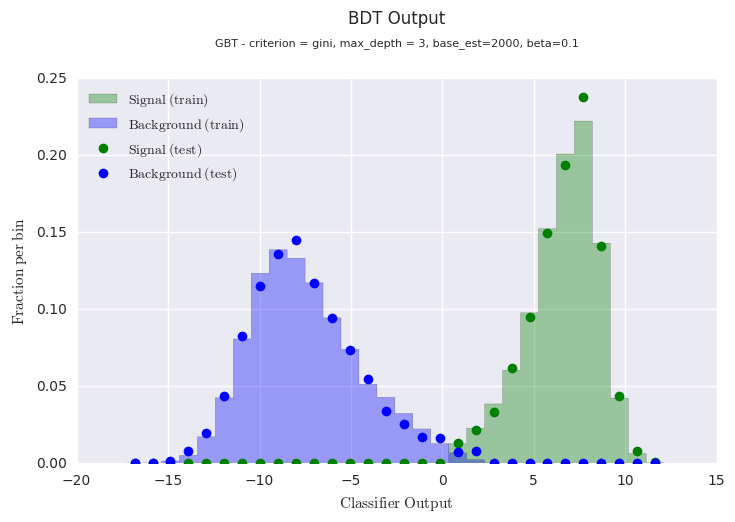

In [45]:
# Plot BDT output for signal/background events
plot_BDT_output(gbt, reduced_X_train, reduced_X_test, y_train, y_test, mode, gbt_meta, 30)

-0.00525763488679 0.0128554058249
-0.0287787716602 0.00583927685671
-0.00553792116986 0.0127325438544
-0.0287173071438 0.00715930794314


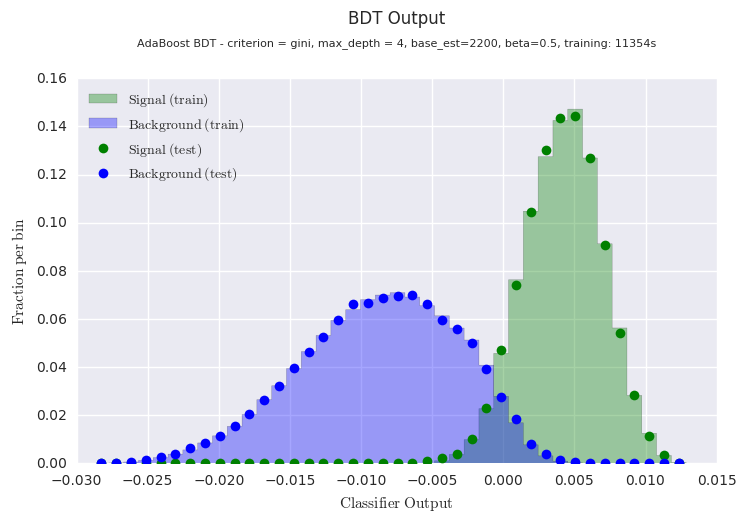

In [39]:
plot_BDT_output(bdt, reduced_X_use, reduced_X_val, y_use, y_val, mode, clf_meta, 40)

### Post Training Histograms

We plot the beam-constrained mass, $m_{bc}$ and $\Delta E$ distributions of our classifier-identified signal and background for the test sets. They should peak at $m_B$ and $0$, respectively. 

In [ ]:
def truth_indices(clf, X, label):
    # Returns indices of data points the classifier has predicted as sig/bkg
    y_pred = clf.predict(X)
    
    if label == 'signal':
        return np.nonzero(y_pred)
    elif label == 'background':
        return np.where(y_pred == 0)
    else:
        raise NameError('Signal or background?')

In [ ]:
predicted_signal = X_val[truth_indices(bdt, reduced_X_val, 'signal')]
predicted_background = X_val[truth_indices(bdt, reduced_X_val, 'background')]

In [ ]:
def post_training_histograms(clf, signal, bkg, mode, branch_names, nbins = 50, columns=None):
    # Plot continuum suppression variable distributions for signal, background
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    
    for variable in columns:
        column_index = branch_names.index(variable)

        var_sig = signal[:, column_index]
        var_bkg = bkg[:, column_index]
        
        # Truncate problematic tails
        var_bkg = truncate_tails(var_bkg)
        
        plt.hist(var_sig, bins=nbins, alpha=0.5, color = sea_green, label = 'Signal', 
                 weights = np.ones(var_sig.shape[0])*1/var_sig.shape[0])
        plt.hist(var_bkg, bins=nbins, alpha=0.3, color = steel_blue, label = 'Background', 
                 weights = np.ones(var_bkg.shape[0])*1/var_bkg.shape[0])
        plt.title(variable)
        #plt.title(r"$\mathrm{"+variable+"{\; - \; (B \rightarrow K^+ \pi^0) \gamma$")
        plt.xlabel(variable)
        plt.ylabel(r'$\mathrm{Fractional \; events/bin}$')
        plt.legend(loc = "upper right")
        plt.savefig('graphs/' + mode + variable + '.pdf', format='pdf', dpi=1000)
        plt.show()
        plt.gcf().clear()

In [ ]:
post_training_histograms(bdt, predicted_signal, predicted_background, 'B2KStargamma', branch_names, nbins = 50, columns=['B_mbc', 'B_deltae']) 

## Figure of Merit

Define the figure of merit as $$ \mathrm{FOM} = \frac{S}{\sqrt{S+B}} $$ Where $S$ and $B$ are the number of signal and background events, as determined by cutting on the BDT output threshold. We aim to find the cut on the classifier output maximizing the signal significance. Other FOMs can easily be handled.

In [218]:
def plot_FOM(clf, X, y, meta_info):
    signal = clf.decision_function(X[y > 0.5])
    background = clf.decision_function(X[y < 0.5])
    start = min(background.min(), signal.min())
    end = max(background.max(), signal.max())
    if abs(start) > 100 or abs(end) > 100:
            prange = (-25,25)   
    else:
        prange = (start,end)
    cuts = np.linspace(prange[0] + 0.1, prange[1] - 0.1, 100)

    FOM = []
    for cut in cuts:
        S = (signal > cut).sum()
        B = (background > cut).sum()
        if (S+B == 0):
            FOM.append(0)
        else:
            FOM.append(S/np.sqrt(S+B))
            
    FOM = np.asarray(FOM)
    plt.figure()
    plt.axes([.1,.1,.8,.7])
    plt.figtext(.5,.9, r'$\mathrm{Signal \; significance}$', fontsize=12, ha='center')
    plt.figtext(.5,.86, meta_info, fontsize=8, ha='center')
    opt = cuts[np.argmax(FOM)]
    plt.plot(cuts, FOM, 'o', color='navy', markersize=4)
    print(opt,FOM.max())
    plt.plot((opt, opt), (0, FOM.max()), 'r--')
    plt.xlim(prange)
    plt.xlabel(r'$\mathrm{BDT \; output}$')
    plt.ylabel(r'$\frac{S}{\sqrt{S+B}}$')
    plt.show()

In [221]:
reduced_X_val.shape

(13838, 25)

In [220]:
plot_FOM(bdt, reduced_X_val, y_val, clf_meta)

/home/justan/anaconda3/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 13838 but corresponding boolean dimension is 129441
  from ipykernel import kernelapp as app


IndexError: index 13840 is out of bounds for axis 0 with size 13838

In [ ]:
plot_FOM(gbt, X_val, y_val, clf_meta)

## Cross Validation

Searching through hyperparameter space presents the risk that the hyperparameters can be adjusted such that classifier learns the 'noise' of the test set and hence generalizes poorly - an undesirable circumstance called *overfitting*. $k$-fold CV parititons the training set into $k$ smaller sets: $k-1$ of the folds are used as training data, and the remaining data is used as validation. The final accuracy reported by $k$-fold CV is the average of the accuracy over $k$ iterations. 

This method does not restrict the number of training samples available, but is computationally expensive and may not be worth undertaking for the marginal improvement it provides. As a general rule, most authors, and empirical evidence, suggest that 5- or 10- fold cross validation should be preferred to Leave-One-Out. <cite data-cite="FHT2009">(HFT, 2009)</cite>

Here we opt for random permutation cross-validation. Samples are first shuffled and then split into a pair of train/test sets. Compared to `KFold` cross-validation, this allows a finer control on the train-test split proportion and the number of validation iterations.

In [ ]:
X_CV, X_test2, y_CV, y_test2 = train_test_split(features, labels,
                                              train_size=25000,
                                              test_size=10000,
                                              random_state=314)

In [ ]:
# Could change classifiers here
# Set model hyperparameters
CRITERION = "gini"
MAX_DEPTH = 5
MIN_SAMPLES_LEAF = 0.02 
MIN_IMPURITY_SPLIT = 1e-7
clf_meta = "AdaBoost BDT - criterion=Gini, max_depth=5, n_est=800, beta=0.5"

# Select base classifier
dt = DecisionTreeClassifier(criterion = CRITERION, max_depth = MAX_DEPTH, min_samples_leaf = MIN_SAMPLES_LEAF, class_weight="balanced") 

# Adaptive boosting algorithm
bdt = AdaBoostClassifier(dt, n_estimators = 800, learning_rate = 0.5)

A [large pool of error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) exist for binary classification. We choose AUC as the test metric during cross-validation, as it is unaffected by the balance of class labels, unlike accuracy.

#### Random permutation X-Val

In [ ]:
from sklearn import cross_validation
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size = 0.1, random_state = 314)

%time scores = cross_validation.cross_val_score(bdt, X_CV, y_CV, cv=cv.split(X_CV), scoring = 'roc_auc', n_jobs=-1, verbose=1)

In [ ]:
print("Cross-Val accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

#### Conventional X-Val

In [ ]:
# Traditional X-val
%time scores = cross_validation.cross_val_score(bdt, X_CV, y_CV, cv=4, scoring = 'roc_auc', n_jobs=-1, verbose=1)

In [ ]:
print("Cross-Val accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

#### Random permutation + Stratification X-Val

This should be run if your classification problem suffers a class imbalance. Stratified sampling attempts to preserve relative class frequencies in each of the train/validation folds.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=5, test_size = 0.1, random_state = 314)

%time scores = cross_validation.cross_val_score(bdt, X_CV, y_CV, cv=cv.split(X_CV), scoring = 'roc_auc', n_jobs=-1, verbose=1)

## Hyperparameter Estimation

Hyperparameters are 'meta-parameters' that are not directly learnt by the algorithm. They are instead passed to the algorithm by the user (eg the number of trees and their maximum depth for BDTs, and the weight decay and dropout probability for neural networks). The optimal set of hyperparameters is context-dependent. 

Cross-validation is a common technique used to scan through hyperparameter space to find a suitable set for the problem at hand.

In [ ]:
# Display hyperparameters for our chosen classifier
bdt.get_params()

### Conventional grid search

In [ ]:
from sklearn import grid_search

# Perform grid search over all combinations of the following hyperparameters
param_grid = [
    {'n_estimators': [100,300,500,1000,1200], 
     'learning_rate': [0.1,0.3,0.8],
     'base_estimator__max_depth': [1,2,3,7]}
#     {'n_estimators': [100,300,500,1000,1200], 
#      'learning_rate': [0.1,0.2,0.8]
#      'max_depth': {1,2,3,7},
#      "base_estimator__criterion" : ["gini", "entropy"],
#      "base_estimator__splitter" :   ["best", "random"}
]

gs = grid_search.GridSearchCV(bdt, param_grid, cv=4, scoring = 'roc_auc', n_jobs=-1)
%time gs.fit(X_CV, y_CV)

### Randomized parameter optimization

If the classifier at hand has many hyperparameters, a brute force grid search may be prohibitively time-consuming. Randomized parameter estimation samples from a specified distribution over possible parameter values and evaluates the classifier performance at random points in hyperparameter space. This can be less computionally intensive than a conventional grid search. 

Additionally, `scikit-learn` offers the option to specify a computational budget - either the number of sampled candidates or sampling iterations. We need access to the distributions in the `scipy.stats` module to sample parameters. 

In [ ]:
import scipy.stats
from sklearn.model_selection import RandomizedSearchCV

# Specify parameter distributions
param_dist = {"base_estimator__max_depth": [3,5,7,None],
              #"base_estimator__criterion": ["gini", "entropy"],
              "base_estimator__max_features": scipy.stats.randint(np.sqrt(len(branch_names)),len(branch_names)),
              "n_estimators": scipy.stats.randint(500,1900),
              "learning_rate": scipy.stats.uniform(loc = 0.3, scale = 0.7)}

In [ ]:
# run the search
n_iter = 100
rs = RandomizedSearchCV(bdt, param_distributions = param_dist, n_iter=n_iter, cv=4, scoring = 'roc_auc', n_jobs=-1, verbose=1)
%time rs.fit(X_CV, y_CV)

### Parameter search report

In [ ]:
def CV_report(gs_results, rs_results):
    # Reporting on x-val scores
    print("")

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
CV_report(gs.cv_results_, rs.cv_results_)

### `TO-DO (2):`
    - Validation curves
    - Randomized grid search
    - Develop better metric for CV
    - Ensemble classifiers
    - **Data transformation with held out data** (!!!)
    - Look into pipelines

## References

<cite data-cite="granger2013">(Friedman, Hastie, Tibshirani, Elements of Statistical Learning, Springer, 2009)</cite>

<cite data-cite="granger2013">(Louis Lyons, Statistics for Nuclear and Particle Physicists, Cambridge University Press, 1986)</cite>

<cite data-cite="baumgartl2014">(Darin Baumgartel, scikit-learn versus TMVA)</cite> https://dbaumgartel.wordpress.com/2014/03/14/machine-learning-examples-scikit-learn-versus-tmva-cern-root/

<cite data-cite="baumgartl2014">(Tim Head, scikit-learn for TMVA users)</cite> https://betatim.github.io/posts/sklearn-for-TMVA-users/

<cite data-cite="baumgartl2014">(Thomas Keck, The Full Event Interpretation, KiT, 2014)</cite> https://ekp-invenio.physik.uni-karlsruhe.de/record/48602/files/EKP-2015-00001.pdf

<cite data-cite="LB, AC"> (L. Breiman, and A. Cutler, “Random Forests”)</cite> http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm

<cite data-cite="baumgartl2014">(Scikit-Learn v0.18.01 Documentation, 2017)</cite> https://scikit-learn.org/stable/modules/cross_validation.html
